# Modelo de Optimización para la Demanda de Queso Costeño

El modelo de optimización presentado está diseñado para gestionar la demanda de queso costeño a través de una plataforma de marketing, utilizando múltiples centros de acopio. El objetivo principal es minimizar los costos asociados con el cumplimiento de la demanda del cliente, considerando los costos de transporte, tiempos de alistamiento y producción potencial en los centros de acopio.

**Variables del Problema**

**N**: Número de centros de acopio.

**CAi**: Identificador del centro de acopio i para i=0…N donde i≠p. Estos centros de acopio complementan las unidades de producto de la demanda que el centro de acopio principal no tiene disponibles. Los centros de acopio **CAi** despachan hacia el centro de acopio principal.

**CAp**: Identificador del centro de acopio principal p (**p**∈[0,N] y **p**≠i). Este centro de acopio atiende directamente al cliente y es responsable de enviar la demanda completa al cliente.

**K(CAi)**: Cantidad del producto que se despacha desde el centro de acopio **CAi**, incluyendo unidades en stock y unidades potenciales que pueden estar listas en poco tiempo.

**Precio(CAi)**: Precio por kilo del producto despachado desde el centro de acopio **CAi**.

**cTransp(CAi)**: Costo del transporte del pedido desde el centro de acopio **CAi** a su destino.

**TiempoAlistam(CAi)**: Tiempo en horas para alistar el pedido desde el centro de acopio **CAi** a su destino.

**TiempoMaxDefinido**: Tiempo máximo definido para considerar la producción potencial.

**TiempoTransp(CAi)**: Tiempo de transporte desde el centro de acopio **CAi** a su destino.

**Tiempo(CAi)**: Tiempo total en horas para que el pedido llegue desde el centro de acopio **CAi** a su destino, sumando el tiempo de alistamiento y el tiempo de transporte.

**cTiempo**: Costo adicional por cada unidad de tiempo contemplado en la variable **Tiempo(CAi)**.

**Demanda**: Cantidad de producto solicitada por el cliente.

**Stock(CAi)**: Stock del producto en el centro de acopio **CAi**.

**Ppotencial(CAi)**: Cantidad de producto que potencialmente puede estar disponible en poco tiempo (potencial del día).

*Código desarrollado para la resolución del problema*

# IMPORTACIONES

In [187]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from prettytable import PrettyTable

# ENTRADA DE DATOS

**demanda**: Cantidad de producto de acuerdo con la categoría del pedido a satisfacer.

**costo_transporte**: Costo por unidad de tiempo de espera para satisfacer la demanda.

**id**:Identificadores de Centro de Acopio (CAi).

**kg**: Stock del Producto en el Centro de Acopio (Stock(CAi)).

**produccion_potencial**: (Ppotencial(CAi)).

**costos_transporte**: (cTransp(CAi)).

**precio**: Precio del Producto por Kilo (Precio(CAi)).

**tiempos_transporte**:Tiempos de Transporte (TiempoTransp(CAi)).

**tiempo_alistamiento**:Tiempos de Alistamiento (TiempoAlistam(CAi)).

In [188]:
datos = {
    "demanda": 600,
    "centros_acopio": [
        {"id": 1, "kg": 2500, "produccion_potencial": 300, "precio": 16000, "tiempo_alistamiento": 2.2},
        {"id": 2, "kg": 1800, "produccion_potencial": 200, "precio": 13000, "tiempo_alistamiento": 1.6},
        {"id": 3, "kg": 1400, "produccion_potencial": 190, "precio": 12000, "tiempo_alistamiento": 1.4},
        {"id": 4, "kg": 2000, "produccion_potencial": 220, "precio": 15000, "tiempo_alistamiento": 2.3},
        {"id": 5, "kg": 1800, "produccion_potencial": 180, "precio": 14000, "tiempo_alistamiento": 2.0},
        {"id": 6, "kg": 1200, "produccion_potencial": 160, "precio": 17000, "tiempo_alistamiento": 1.8},
        {"id": 7, "kg": 1600, "produccion_potencial": 180, "precio": 18000, "tiempo_alistamiento": 2.5},
        {"id": 8, "kg": 1400, "produccion_potencial": 200, "precio": 19000, "tiempo_alistamiento": 2.1},
        {"id": 9, "kg": 1200, "produccion_potencial": 160, "precio": 11000, "tiempo_alistamiento": 1.3},
    ],
    "costos_transporte": [
        [0, 6, 8, 7, 9, 8, 10, 11, 12],
        [6, 0, 4, 5, 6, 7, 8, 9, 10],
        [8, 4, 0, 6, 5, 7, 9, 8, 11],
        [7, 5, 6, 0, 7, 8, 9, 10, 12],
        [9, 6, 5, 7, 0, 9, 8, 10, 11],
        [8, 7, 7, 8, 9, 0, 6, 9, 10],
        [10, 8, 9, 9, 8, 6, 0, 7, 8],
        [11, 9, 8, 10, 10, 9, 7, 0, 6],
        [12, 10, 11, 12, 11, 10, 8, 6, 0]
    ],
    "tiempos_transporte": [
        [0, 1.2, 2.2, 1.8, 2.3, 2.0, 2.3, 2.4, 2.6],
        [1.2, 0, 1.2, 1.4, 1.6, 1.4, 1.9, 2.0, 2.3],
        [2.2, 1.2, 0, 1.5, 1.6, 1.7, 2.2, 1.8, 2.2],
        [1.8, 1.4, 1.5, 0, 1.8, 1.6, 2.0, 2.2, 2.4],
        [2.3, 1.6, 1.6, 1.8, 0, 1.8, 2.0, 1.9, 2.4],
        [2.0, 1.4, 1.7, 1.6, 1.8, 0, 1.9, 2.0, 2.1],
        [2.3, 1.9, 2.2, 2.0, 2.0, 1.9, 0, 1.6, 1.9],
        [2.4, 2.0, 1.8, 2.2, 1.9, 2.0, 1.6, 0, 1.7],
        [2.6, 2.3, 2.2, 2.4, 2.4, 2.1, 1.9, 1.7, 0]
    ],
        "costo_tiempo": 2.5,  
        "tiempo_maximo_definido": 72
    
}

# CREACIÓN DEL MODELO

In [189]:
model = pyo.ConcreteModel()

# CONJUNTOS

In [190]:
model.I = pyo.RangeSet(0, len(datos['centros_acopio']) - 1)  # Centros de acopio

# PARAMETROS

In [191]:
model.Demanda = pyo.Param(initialize=datos['demanda'])
model.Stock = pyo.Param(model.I, initialize={i: datos['centros_acopio'][i]['kg'] for i in model.I})
model.Pproduccion = pyo.Param(model.I, initialize={i: datos['centros_acopio'][i]['produccion_potencial'] for i in model.I})
model.Precio = pyo.Param(model.I, initialize={i: datos['centros_acopio'][i]['precio'] for i in model.I})
model.cTransp = pyo.Param(model.I, model.I, initialize={(i, j): datos['costos_transporte'][i][j] for i in model.I for j in model.I})
model.tTransp = pyo.Param(model.I, model.I, initialize={(i, j): datos['tiempos_transporte'][i][j] for i in model.I for j in model.I})
model.tAlistam = pyo.Param(model.I, initialize={i: datos['centros_acopio'][i]['tiempo_alistamiento'] for i in model.I})
model.cTiempo = pyo.Param(initialize=datos['costo_tiempo'])
model.tMax = pyo.Param(initialize=datos['tiempo_maximo_definido'])

# SELECCIÓN DEL CENTRO DE ACOPIO PRINCIPAL

Selección automática del centro principal basado en el costo más bajo

In [192]:
centro_principal_id = min(model.I, key=lambda i: datos['centros_acopio'][i]['precio'])
model.CentroPrincipal = pyo.Param(initialize=centro_principal_id)

# VARIABLES

In [193]:
model.X = pyo.Var(model.I, within=pyo.NonNegativeReals)  # Cantidad despachada desde cada centro
model.Y = pyo.Var(model.I, model.I, within=pyo.NonNegativeReals)  # Cantidad transportada entre centros

# FUNCIÓN OBJETIVO

\begin{equation}
\text{Minimizar} \quad \sum_{i=1, i \neq p}^{N} \left[ K(CAi) \cdot Precio(CAi) + K(CAi) \cdot cTransp(CAi) + Tiempo(CAi) \cdot cTiempo \right] + \left[ K(CAp) \cdot Precio(CAp) + Demanda \cdot cTransp(CAp) + Tiempo(CAp) \cdot cTiempo \right]
\end{equation}

In [194]:
model.CostoTotal = pyo.Objective(
    rule=lambda model: sum(model.Precio[i] * model.X[i] for i in model.I) + sum(model.cTransp[i, model.CentroPrincipal] * model.Y[i, model.CentroPrincipal] for i in model.I if i != model.CentroPrincipal),
    sense=pyo.minimize
)

# RESTRICCIONES 

\begin{equation}
\sum_{i=0}^{N} K(CAi) = Demanda
\end{equation}

\begin{equation}
K(CAi) \leq Stock(CAi) + P_{\text{potencial}}(CAi) \quad \text{para } i=0\ldots N
\end{equation}

\begin{equation}
Tiempo(CAi) = Tiempo_{\text{Alistam}}(CAi) + Tiempo_{\text{Transp}}(CAi)
\end{equation}

\begin{equation}
Tiempo_{\text{Alistam}}(CAi) \leq Tiempo_{\text{MaxDefinido}} \quad \text{para } i=0\ldots N
\end{equation}

In [195]:
model.DemandaSatisfecha = pyo.Constraint(expr=sum(model.X[i] for i in model.I) == model.Demanda)

model.StockDisponible = pyo.Constraint(model.I, rule=lambda model, i: model.X[i] <= model.Stock[i])

model.ProduccionPotencial = pyo.Constraint(model.I, rule=lambda model, i: model.X[i] <= model.Pproduccion[i])

model.TiempoMax = pyo.Constraint(model.I, rule=lambda model, i: model.tAlistam[i] + sum(model.tTransp[i, j] * model.Y[i, j] for j in model.I) <= model.tMax)

model.BalanceTransport = pyo.Constraint(model.I, rule=lambda model, i: sum(model.Y[j, i] for j in model.I) == model.X[i] if i != model.CentroPrincipal else pyo.Constraint.Skip)

model.CentroPrincipalManejo = pyo.Constraint(expr=sum(model.Y[i, model.CentroPrincipal] for i in model.I) == model.X[model.CentroPrincipal])

# RESOLVER MODELO

In [196]:
solver = pyo.SolverFactory('glpk')
results = solver.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpdjh5bcfq.glpk.raw --wglp /tmp/tmpixxstyay.glpk.glp --cpxlp
 /tmp/tmpqad1yb0q.pyomo.lp
Reading problem data from '/tmp/tmpqad1yb0q.pyomo.lp'...
37 rows, 90 columns, 189 non-zeros
416 lines were read
Writing problem data to '/tmp/tmpixxstyay.glpk.glp'...
364 lines were written
GLPK Simplex Optimizer 5.0
37 rows, 90 columns, 189 non-zeros
Preprocessing...
19 rows, 81 columns, 162 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.600e+00  ratio =  2.600e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 19
      0: obj =   6.600000000e+06 inf =   4.400e+02 (1)
      2: obj =   8.380000000e+06 inf =   0.000e+00 (0)
*     5: obj =   7.340000000e+06 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (97717 bytes)
Writing basic solution to '/tmp/tmpdjh5bcfq.glpk.raw'...
136 lines were written


# REPRESENTACIÓN DE DATOS


Representación de stocks:


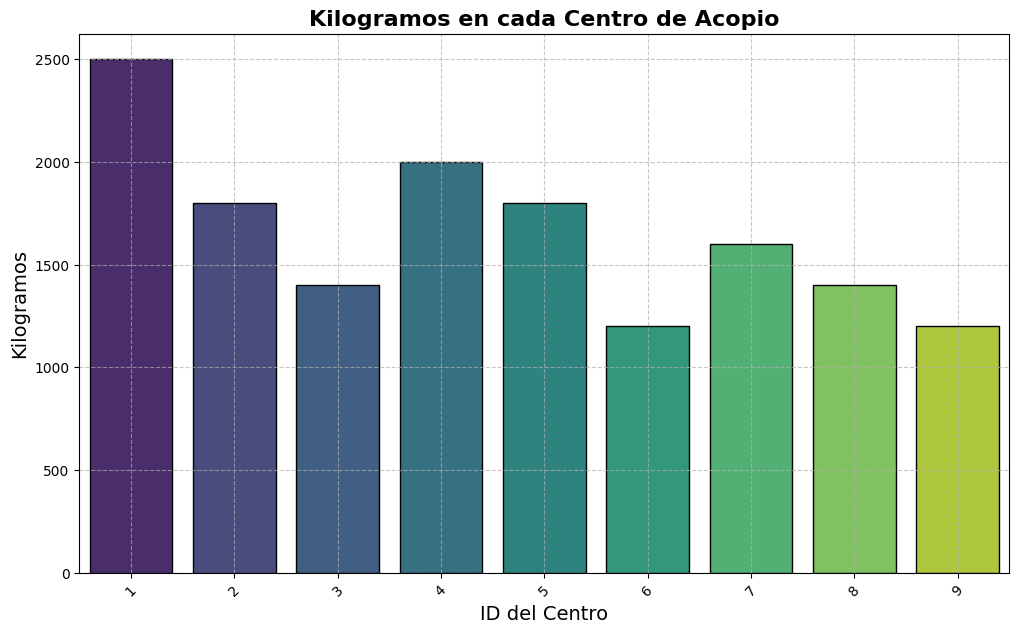

In [197]:
print("\nRepresentación de stocks:")

df_centros = pd.DataFrame(datos['centros_acopio'])
plt.figure(figsize=(12, 7))
sns.barplot(x='id', y='kg', data=df_centros, palette='viridis', edgecolor='black')
plt.title('Kilogramos en cada Centro de Acopio', fontsize=16, weight='bold')
plt.xlabel('ID del Centro', fontsize=14)
plt.ylabel('Kilogramos', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [198]:
# Crear tabla para los centros de acopio
centros_acopio = datos["centros_acopio"]
headers = ["ID", "KG", "Producción Potencial", "Precio", "Tiempo Alistamiento"]
table = [[c["id"], c["kg"], c["produccion_potencial"], c["precio"], c["tiempo_alistamiento"]] for c in centros_acopio]
print("Centros de Acopio:")
print(tabulate(table, headers=headers, tablefmt='grid'))
print()


# Mostrar costos de transporte en matriz
print("Matriz 'Costos de Transporte':")
print(tabulate(datos["costos_transporte"], tablefmt='grid'))
print()
# Crear tabla para la matriz de costos de transporte
table = PrettyTable()
table.field_names = [""] + [f"Centro {i}" for i in range(len(datos["costos_transporte"]))]
for i, row in enumerate(datos["costos_transporte"]):
    table.add_row([f"Centro {i+1}"] + row)

print("Tabla 'Costos de Transporte':")
print(table)
print()

# Mostrar tiempos de transporte
print("Matriz 'Tiempos de Transporte':")
print(tabulate(datos["tiempos_transporte"], tablefmt='grid'))
print()

# Crear tabla para la matriz de tiempos de transporte
table = PrettyTable()
table.field_names = [""] + [f"Centro {i}" for i in range(len(datos["tiempos_transporte"]))]
for i, row in enumerate(datos["tiempos_transporte"]):
    table.add_row([f"Centro {i+1}"] + row)

print("Tabla 'Tiempos de Transporte':")
print(table)
print()

# Mostrar costos y tiempos adicionales
print(f"Costo Tiempo: {datos['costo_tiempo']}\n")
print(f"Tiempo Máximo Definido: {datos['tiempo_maximo_definido']}")


Centros de Acopio:
+------+------+------------------------+----------+-----------------------+
|   ID |   KG |   Producción Potencial |   Precio |   Tiempo Alistamiento |
+======+======+========================+==========+=======================+
|    1 | 2500 |                    300 |    16000 |                   2.2 |
+------+------+------------------------+----------+-----------------------+
|    2 | 1800 |                    200 |    13000 |                   1.6 |
+------+------+------------------------+----------+-----------------------+
|    3 | 1400 |                    190 |    12000 |                   1.4 |
+------+------+------------------------+----------+-----------------------+
|    4 | 2000 |                    220 |    15000 |                   2.3 |
+------+------+------------------------+----------+-----------------------+
|    5 | 1800 |                    180 |    14000 |                   2   |
+------+------+------------------------+----------+------------------

# RESULTADOS

# Solución óptima

**Centros elegidos y cantidad asignada:**

In [199]:
for i in model.I:
    try:
        print(f"Centro {i}: = {pyo.value(model.X[i]):.2f}")
    except ValueError:
        print(f"Centro {i}: Cantidad despachada no disponible")

Centro 0: = 0.00
Centro 1: = 200.00
Centro 2: = 190.00
Centro 3: = 0.00
Centro 4: = 50.00
Centro 5: = 0.00
Centro 6: = 0.00
Centro 7: = 0.00
Centro 8: = 160.00


**Centros involucrados**

In [200]:
centros_despachados = set()

for i in model.I:
    for j in model.I:
        try:
            value_Y = pyo.value(model.Y[i, j])
            if value_Y > 0:
                centros_despachados.add(i)
                centros_despachados.add(j)
        except KeyError:
            print(f"Índice {i}, {j} no es válido para el componente model.Y.")
        except ValueError:
            print(f"Cantidad transportada de Centro {i} a Centro {j} no disponible")

for centro in centros_despachados:
    print(f"Centro {centro}: Cantidad por despachar")


Centro 8: Cantidad por despachar
Centro 1: Cantidad por despachar
Centro 2: Cantidad por despachar
Centro 4: Cantidad por despachar


**Centro principal para la demanda del cliente**

In [201]:
print(f"\nCentro principal seleccionado: {model.CentroPrincipal.value}")


Centro principal seleccionado: 8


**Resumen de operación al centro principal**

In [202]:
total_costo_transporte = 0

for i in model.I:
    if i != model.CentroPrincipal:
        try:
            cantidad_transportada = sum(model.Y[i, j].value for j in model.I)
            costo_transportado = cantidad_transportada * model.cTransp[i, model.CentroPrincipal]
            total_costo_transporte += costo_transportado
            print(f'\nCentro {i}: Despachado = {model.X[i].value:.2f}. \nCantidad para transportar al centro principal {model.CentroPrincipal.value} = {cantidad_transportada:.2f}. \nCosto transporte = ${costo_transportado:.2f}')
        except ValueError:
            print(f'Centro {i}: Despachado o cantidad transportada no disponible')



Centro 0: Despachado = 0.00. 
Cantidad para transportar al centro principal 8 = 0.00. 
Costo transporte = $0.00

Centro 1: Despachado = 200.00. 
Cantidad para transportar al centro principal 8 = 200.00. 
Costo transporte = $2000.00

Centro 2: Despachado = 190.00. 
Cantidad para transportar al centro principal 8 = 190.00. 
Costo transporte = $2090.00

Centro 3: Despachado = 0.00. 
Cantidad para transportar al centro principal 8 = 0.00. 
Costo transporte = $0.00

Centro 4: Despachado = 50.00. 
Cantidad para transportar al centro principal 8 = 50.00. 
Costo transporte = $550.00

Centro 5: Despachado = 0.00. 
Cantidad para transportar al centro principal 8 = 0.00. 
Costo transporte = $0.00

Centro 6: Despachado = 0.00. 
Cantidad para transportar al centro principal 8 = 0.00. 
Costo transporte = $0.00

Centro 7: Despachado = 0.00. 
Cantidad para transportar al centro principal 8 = 0.00. 
Costo transporte = $0.00


**Costo total del producto**

In [203]:
print(f"\nCosto total del modelo de optimización: = ${pyo.value(model.CostoTotal):,.2f}")


Costo total del modelo de optimización: = $7,340,000.00


**Costo total del transporte centros a centro principal**

In [204]:
print(f"\n\nCosto total del transporte centros a centro principal: = ${total_costo_transporte:.2f}")



Costo total del transporte centros a centro principal: = $4640.00
